# Efficient Continuous Pareto Exploration in Multi-Task Learning

Source code for ICML submission #640 "Efficient Continuous Pareto Exploration in Multi-Task Learning"

This script generates Figure 5 in the paper.

# Module Importation

In [1]:
from pathlib import Path
import codecs
import gzip
import os
import urllib
import pickle
import random
from itertools import product
from functools import partial
from contextlib import contextmanager
from tqdm.notebook import tqdm, trange

import cvxpy as cp
import numpy as np
import scipy
from scipy import ndimage
import scipy.optimize
from scipy.sparse.linalg import LinearOperator, minres
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torchvision.transforms as transforms

from common import *
from min_norm_solver import find_min_norm_element

%matplotlib inline

# Random seed fixation

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Dataset definition

In [3]:
class MultiMNIST(torch.utils.data.Dataset):
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pth'
    test_file = 'test.pth'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = Path(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if train:
            self.data, self.labels_l, self.labels_r = torch.load(
                self.root / self.processed_folder /self.training_file)
        else:
            self.data, self.labels_l, self.labels_r = torch.load(
                self.root / self.processed_folder / self.test_file)

        if transform is not None:
            self.data = [self.transform(Image.fromarray(
                img.numpy().astype(np.uint8), mode='L')) for img in self.data]

    def __getitem__(self, index):
        img, target_l, target_r = self.data[index], self.labels_l[index], self.labels_r[index]

        return img, torch.stack([target_l, target_r])

    def __len__(self):
        return len(self.data)

    def _check_exists(self):
        return (self.root / self.processed_folder / self.training_file).is_file() and \
            (self.root / self.processed_folder / self.test_file).is_file()

    def download(self):
        if self._check_exists():
            return

        # download files
        (self.root / self.raw_folder).mkdir(parents=True, exist_ok=True)
        (self.root / self.processed_folder).mkdir(parents=True, exist_ok=True)

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = self.root / self.raw_folder / filename
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(self.root / self.raw_folder / '.'.join(filename.split('.')[:-1]), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            file_path.unlink()

        # process and save as torch files
        print('Processing...')
        multi_mnist_ims, extension = self.read_image_file(
            self.root / self.raw_folder / 'train-images-idx3-ubyte', shift_pix=4, rand_shift=True)
        multi_mnist_labels_l, multi_mnist_labels_r = self.read_label_file(
            self.root / self.raw_folder / 'train-labels-idx1-ubyte', extension)

        tmulti_mnist_ims, textension = self.read_image_file(
            self.root / self.raw_folder / 't10k-images-idx3-ubyte', shift_pix=4, rand_shift=True)
        tmulti_mnist_labels_l, tmulti_mnist_labels_r = self.read_label_file(
            self.root / self.raw_folder / 't10k-labels-idx1-ubyte', textension)

        multi_mnist_training_set = (multi_mnist_ims, multi_mnist_labels_l, multi_mnist_labels_r)
        multi_mnist_test_set = (tmulti_mnist_ims, tmulti_mnist_labels_l, tmulti_mnist_labels_r)

        with open(self.root / self.processed_folder / self.training_file, 'wb') as f:
            torch.save(multi_mnist_training_set, f)
        with open(self.root / self.processed_folder / self.test_file, 'wb') as f:
            torch.save(multi_mnist_test_set, f)
        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(
            tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(
            tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

    @staticmethod
    def get_int(b):
        return int(codecs.encode(b, 'hex'), 16)

    @staticmethod
    def read_label_file(path, extension):
        with open(path, 'rb') as f:
            data_1 = f.read()
            assert MultiMNIST.get_int(data_1[:4]) == 2049
        with open(path, 'rb') as f:
            data_2 = f.read()
            assert MultiMNIST.get_int(data_2[:4]) == 2049
        length = MultiMNIST.get_int(data_1[4:8])
        parsed_1 = np.frombuffer(data_1, dtype=np.uint8, offset=8)
        parsed_2 = np.frombuffer(data_2, dtype=np.uint8, offset=8)
        multi_labels_l = np.zeros(length, dtype=np.long)
        multi_labels_r = np.zeros(length, dtype=np.long)
        for im_id in range(length):
            multi_labels_l[im_id] = parsed_1[im_id]
            multi_labels_r[im_id] = parsed_2[extension[im_id]]
        return (torch.from_numpy(multi_labels_l).view(-1).long(),
                torch.from_numpy(multi_labels_r).view(-1).long())

    @staticmethod
    def read_image_file(path, shift_pix=4, rand_shift=True, rot_range=(0, 0), corot=True):
        with open(path, 'rb') as f:
            data_1 = f.read()
            assert MultiMNIST.get_int(data_1[:4]) == 2051
        with open(path, 'rb') as f:
            data_2 = f.read()
            assert MultiMNIST.get_int(data_2[:4]) == 2051
        length = MultiMNIST.get_int(data_1[4:8])
        num_rows = MultiMNIST.get_int(data_1[8:12])
        num_cols = MultiMNIST.get_int(data_1[12:16])
        parsed_1 = np.frombuffer(data_1, dtype=np.uint8, offset=16)
        pv_1 = parsed_1.reshape(length, num_rows, num_cols)
        parsed_2 = np.frombuffer(data_2, dtype=np.uint8, offset=16)
        pv_2 = parsed_2.reshape(length, num_rows, num_cols)
        multi_data = np.zeros((length, num_rows, num_cols))
        extension = np.zeros(length, dtype=np.int32)
        rights = np.random.permutation(length)
        for left in range(length):
            extension[left] = rights[left]
            lim = pv_1[left, :, :]
            rim = pv_2[rights[left], :, :]
            if not rot_range[0] == rot_range[1] == 0:
                if corot:
                    rot_deg = random.randint(rot_range[0], rot_range[1])
                    lim = ndimage.rotate(lim, rot_deg, reshape=False)
                    rim = ndimage.rotate(rim, rot_deg, reshape=False)
                else:
                    rot_deg = random.randint(rot_range[0], rot_range[1])
                    lim = ndimage.rotate(lim, rot_deg, reshape=False)
                    rot_deg = random.randint(rot_range[0], rot_range[1])
                    rim = ndimage.rotate(rim, rot_deg, reshape=False)
            # in case of 100% overlapping
            shift_pix1 = shift_pix2 = 0
            if rand_shift:
                if random.choice([True, False]):
                    shift_pix1 = random.randint(0, shift_pix - 1)
                    shift_pix2 = random.randint(0, shift_pix)
                else:
                    shift_pix1 = random.randint(0, shift_pix)
                    shift_pix2 = random.randint(1, shift_pix)
            new_im = np.zeros((36, 36))
            new_im[shift_pix1:shift_pix1 + 28, shift_pix1:shift_pix1 + 28] += lim
            new_im[shift_pix2 + 4:shift_pix2 + 4 + 28, shift_pix2 + 4:shift_pix2 + 4 + 28] += rim
            new_im = np.clip(new_im, 0, 255)
            multi_data_im = np.array(Image.fromarray(new_im).resize((28, 28), resample=Image.NEAREST))
            multi_data[left, :, :] = multi_data_im
        return torch.from_numpy(multi_data).view(length, num_rows, num_cols), extension


# Dataset illustration

In [4]:
dataset = MultiMNIST(root='./MultiMNIST', train=True, download=True)

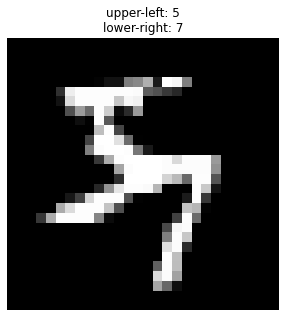

In [5]:
fig = plt.figure(figsize=(5, 5))
plt.title('upper-left: {}\nlower-right: {}'.format(
    dataset[0][1][0], dataset[0][1][1]))
plt.imshow(dataset[0][0].clone().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# PyTorch initialization

- working directory
- device
- dataloader
- utilities

### Checkpoint paths

In [6]:
ckpt_root = Path('./MultiMNIST/checkpoints')
ckpt_root.mkdir(parents=True, exist_ok=True)

sgd_path = ckpt_root / 'sgd'
sgd_path.mkdir(parents=True, exist_ok=True)

mr_path = ckpt_root / 'minres'
mr_path.mkdir(parents=True, exist_ok=True)

print('Checkpoint root:', ckpt_root)
print('SGD path:       ', sgd_path)
print('MINRES path:    ', mr_path)

Checkpoint root: MultiMNIST/checkpoints
SGD path:        MultiMNIST/checkpoints/sgd
MINRES path:     MultiMNIST/checkpoints/minres


### Computating device initialization
We remove all random state.

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # use default cuda device
    import torch.backends.cudnn as cudnn  # make cuda deterministic
    cudnn.benchmark = False
    cudnn.deterministic = True
else:
    device = torch.device('cpu') # otherwise use cpu

print('Current device:', device)

Current device: cuda


### Training and test dataloader
We use batch size of 256 for both training and test side.

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = MultiMNIST('./MultiMNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True, num_workers=0)

testset = MultiMNIST('./MultiMNIST', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

print('Training Dataset:')
print(trainset)
print()

print('Test Dataset:')
print(testset)

Training Dataset:
Dataset MultiMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: MultiMNIST
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

Test Dataset:
Dataset MultiMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: MultiMNIST
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


### Utility functions
- evenly distributed weights
- top-k accuracies
- evaluation

In [9]:
def evenly_dist(num_weights, dim=2):
    return [ret for ret in product(np.linspace(0.0, 1.0, num_weights + 2), repeat=dim) \
            if round(sum(ret), 6) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

def topk_accuracies(logits, targets, ks=(1,)):
    assert logits.dim() == 2
    assert targets.dim() == 1
    assert logits.size(0) == targets.size(0)

    maxk = max(ks)
    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    targets = targets.unsqueeze(1).expand_as(pred)
    correct = pred.eq(targets).float()

    accu_list = []
    for k in ks:
        accu = correct[:, :k].sum(1).mean()
        accu_list.append(accu.item())
    return accu_list

def evaluate(network, dataloader, closures, topk_closures):
    num_samples = 0
    total_losses = np.zeros(len(closures))
    total_top1s = np.zeros(len(closures))
    with torch.no_grad():
        network.train(False)
        for images, targets in dataloader:
            batch_size = len(images)
            num_samples += batch_size
            images = images.to(device)
            targets = targets.to(device)
            logits = network(images)
            losses = [c(network, logits, targets).item() for c in closures]
            total_losses += batch_size * np.array(losses)
            topks = [c(network, logits, targets) for c in topk_closures]
            total_top1s += batch_size * np.array(topks)
    total_losses /= num_samples
    total_top1s /= num_samples
    return total_losses, total_top1s

print('Example of evenly_dist(num_weights=5, dim=2):')
for i, combination in enumerate(evenly_dist(5, dim=2)):
    print('{:d}: ('.format(i + 1) + ', '.join(['{:.3f}'.format(digit) for digit in combination]) + ')')

Example of evenly_dist(num_weights=5, dim=2):
1: (0.167, 0.833)
2: (0.333, 0.667)
3: (0.500, 0.500)
4: (0.667, 0.333)
5: (0.833, 0.167)


# Empirical Pareto front generation

- hyper-parameters
- network
- loss function
- optimizer
- learning rate scheduler
- inital state snapshot

### Hyper-Parameters declaration
- num of epochs
- num of different weight combinations

In [10]:
num_epochs = 30
num_weights = 5

### Network definition

We use a modified LeNet with a fully-connected layer for each task.

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, (5, 5))
        self.conv2 = nn.Conv2d(10, 20, (5, 5))
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        self.fc3_1 = nn.Linear(50, 10)
        self.fc3_2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = [self.fc3_1(x), self.fc3_2(x)]
        return x

network = LeNet()
network.to(device)

print('Network:')
print(network)

Network:
LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc3_1): Linear(in_features=50, out_features=10, bias=True)
  (fc3_2): Linear(in_features=50, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
)


### Loss function definition
We use cross entropy loss for two tasks.

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
closures = [
    lambda n, l, t: criterion(l[0], t[:, 0]),
    lambda n, l, t: criterion(l[1], t[:, 1])
]
top1_closures = [
    lambda n, l, t: topk_accuracies(l[0], t[:, 0], ks=(1,))[0],
    lambda n, l, t: topk_accuracies(l[1], t[:, 1], ks=(1,))[0]
]

### Optimizer definition
We use SGD with learning rate of 0.01 and momentum of 0.9.

In [13]:
optimizer = SGD(network.parameters(), lr=0.01, momentum=0.9)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Learning rate scheduler definition
We use cosine annealing learning rate scheduler for training.

In [14]:
lr_scheduler = CosineAnnealingLR(optimizer, num_epochs * len(trainloader))

### Snapshot for inital states

The initial weights/optimizer/lr_scheduler are saved for further training (we removed **ALL** randomness).

In [15]:
init_ckpt = {
    'state_dict': network.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_scheduler': lr_scheduler.state_dict()
}
torch.save(init_ckpt, sgd_path / 'init.pth')

# Let's train it!

In [16]:
for i, weight in enumerate(tqdm(evenly_dist(num_weights, 2), desc='Weight', leave=False)):
    init_ckpt = torch.load(sgd_path / 'init.pth', map_location='cpu')  # load init snapshot
    network.load_state_dict(init_ckpt['state_dict'])
    optimizer.load_state_dict(init_ckpt['optimizer'])
    lr_scheduler.load_state_dict(init_ckpt['lr_scheduler'])
    with trange(num_epochs, desc='Epoch') as epoch_iter:
        for epoch in epoch_iter:
            network.train(True)
            for images, targets in tqdm(trainloader, desc='Batch', leave=False):
                images = images.to(device)
                targets = targets.to(device)
                logits = network(images)
                losses = [c(network, logits, targets) for c in closures]
                loss = sum(w * l for w, l in zip(weight, losses))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            eval_losses, eval_top1s = evaluate(network, testloader, closures, top1_closures)
            epoch_iter.set_postfix(**{'acc-{:d}'.format(i + 1): top for i, top in enumerate(eval_top1s)})
    ckpt = {
        'state_dict': network.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'metrics': [eval_losses, eval_top1s]
    }
    torch.save(ckpt, sgd_path / '{:d}.pth'.format(i))

# SGD results illustration

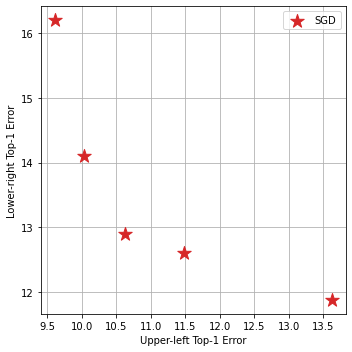

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
total_top1s = []
for i in range(num_weights):
    ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
    losses, top1s = ckpt['metrics']
    total_top1s.append(top1s)
total_err1s = 100.0 * (1.0 - np.stack(total_top1s, axis=0).T)
ax.scatter(*total_err1s, color='tab:red', marker='*', s=200, label='SGD')
ax.set_xlabel('Upper-left Top-1 Error')
ax.set_ylabel('Lower-right Top-1 Error')
ax.grid(True)
ax.set_axisbelow(True)
ax.legend()
fig.tight_layout()
plt.show()

# MINRES initalization
- hyper-parameters
- dataloader
- optimizer
- Jacobian solver
- linear operator
- utilities

### Hyper-Parameters declaration
- num of steps
- damping for linear solver
- maxiter for MINRES
- momentum for Jacobians and alpha

In [18]:
num_steps = 10
damping = 0.1
maxiter = 50
momentum = 0.9

### Dataloader definition

We explore based on 2048 data samples.

In [19]:
mr_dataloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True, drop_last=True, num_workers=0)

### Optimizer definition
We use SGD with learning rate of 0.1 (**without** momentum for fair)

In [20]:
mr_optimizer = SGD(network.parameters(), lr=0.1)

print(mr_optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Jacobians solver definition
We iterate over trainset to solve jacobian with respect to each task.

In [21]:
jacobian_trainiter = iter(trainloader)
def compute_jacobians(ratio=1.0):
    global jacobian_trainiter
    num_batches = int(len(trainloader) * ratio)
    jacobians = None
    for _ in range(num_batches):
        try:
            images, targets = next(jacobian_trainiter)
        except StopIteration:
            jacobian_trainiter = iter(trainloader)
            images, targets = next(jacobian_trainiter)
        images = images.to(device)
        targets = targets.to(device)
        logits = network(images)
        losses = [c(network, logits, targets) for c in closures]
        param_grads = [list(torch.autograd.grad(
            l, network.parameters(), allow_unused=True,
            retain_graph=True, create_graph=False)) for l in losses]
        for param_grad in param_grads:
            for i, (param_grad_module, param) in enumerate(zip(param_grad, network.parameters())):
                if param_grad_module is None:
                    param_grad[i] = torch.zeros_like(param)
        sub_jacobians = torch.stack([parameters_to_vector(param_grad) for param_grad in param_grads], dim=0)
        sub_jacobians.detach_()
        if jacobians is None:
            jacobians = sub_jacobians
        else:
            jacobians.add_(sub_jacobians)
    jacobians.div_(num_batches)
    return jacobians.clone().detach()

### Alpha solver definition
We solve alpha by its analytical solution.

In [22]:
def compute_alpha(jacobians):
    sol, min_norm = find_min_norm_element(jacobians)
    return sol

### Linear operator for Hessian-vector product definition
We warp Hessian-vector product into a linear operator to prevent explicit computation of Hessian.

In [23]:
class HVPLinearOperator(LinearOperator):
    def __init__(self, dataloader):
        network_size = sum(p.numel() for p in network.parameters())
        shape = (network_size, network_size)
        dtype = list(network.parameters())[0].detach().cpu().numpy().dtype

        super(HVPLinearOperator, self).__init__(dtype, shape)

        self.dataloader = dataloader
        self.dataiter = iter(dataloader)

        self.alpha_jacobians = None

    def _get_jacobians(self):
        try:
            images, targets = next(self.dataiter)
        except StopIteration:
            self.dataiter = iter(self.dataloader)
            images, targets = next(self.dataiter)
        images = images.to(device)
        targets = targets.to(device)
        logits = network(images)
        losses = [c(network, logits, targets) for c in closures]
        
        # Get jacobian with respect to each loss.
        # `allow_unused=True` to get gradient from the unused tail.
        #     It returns `None`, which will be filtered later.
        # `retain_graph=True` to retain forward information for
        #     second-time backward.
        # `create_graph=True` to create computation graph for
        #     second-order derivation.
        param_grads = [list(torch.autograd.grad(
            l, network.parameters(), allow_unused=True,
            retain_graph=True, create_graph=True)) for l in losses]

        # As metioned above, `allow_unused=True` leads to `None`s in
        #     jacobian tuple. Now we replace it with a zero tensor.
        for param_grad in param_grads:
            for i, (param_grad_module, param) in enumerate(zip(param_grad, network.parameters())):
                if param_grad_module is None:
                    param_grad[i] = torch.zeros_like(param)
                    
        return torch.stack([parameters_to_vector(param_grad) for param_grad in param_grads], dim=0)

    @contextmanager
    def init(self, alpha):
        try:
            alpha = torch.as_tensor(alpha.astype(self.dtype), device=device).view(1, -1)
            jacobians = self._get_jacobians()
            self.alpha_jacobians = alpha.matmul(jacobians).squeeze()
            yield self
        finally:
            self.alpha_jacobians = None

    def _matvec_tensor(self, tensor):

        # hvp = Hv
        #     = dot(∂^2(f) / (∂x)^2, v)
        #     = ∂/∂x(dot(v, ∂f/∂x))

        # dot = dot(v, ∂f/∂x)
        dot = self.alpha_jacobians.dot(tensor)
        
        # hvp = ∂/∂x(dot)
        param_alphas_hvps = torch.autograd.grad(dot, network.parameters(), retain_graph=True)
        alphas_hvps = parameters_to_vector([p.contiguous() for p in param_alphas_hvps])

        if damping > 0.0:
            alphas_hvps.add_(tensor, alpha=damping)
        return alphas_hvps

    def _matvec(self, x):
        """HVP matrix-vector multiplication handler.

        If self is a linear operator of shape (N, N), then this method will
        be called on a shape (N,) or (N, 1) ndarray, and should return a
        shape (N,) or (N, 1) ndarray.

        In our case, it computes alpha_hession @ x.
        """
        tensor = torch.as_tensor(x.astype(self.dtype), device=device)
        ret = self._matvec_tensor(tensor)
        return ret.detach().cpu().numpy()

### Utility functions
- assign parameter.grad from vector

In [24]:
def assign_grad(vector, normalize=True):
    if normalize:
        vector.div_(vector.norm())
    offset = 0
    for p in network.parameters():
        numel = p.numel()
        # view as to avoid deprecated pointwise semantics
        p.grad = vector[offset:offset + numel].view_as(p.data).clone()
        offset += numel

# Let's explore it!
Executing this section takes around 5 to 10 minutes depending on your GPU types. However, for the results reported in the paper and supplemental material, our training process is typically a lot faster than here because of the following reasons:

- For reproducibility, we disable randomness in this script as much as we can. Therefore, parallalism on GPUs is not fully exploited;
- We frequently evaluate and save the model inside the innermost loop, which creates a lot of overhead;
- Since the MINRES implementation is from scipy and is on CPUs, calling `HVPLinearOperator` creates a lot of CPU-GPU communication. Ideally, a GPU implementation of MINRES could completely remove this communication and expedite the training process.

In [25]:
linear_op_template = HVPLinearOperator(mr_dataloader)

In [26]:
for i in trange(num_weights, desc='Weight', leave=False):
    for col in trange(2, desc='Direction', leave=False):
        
        # load SGD starting point
        init_ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
        network.load_state_dict(init_ckpt['state_dict'])

        # initalize momentum buffer
        jacobians_buffer_tensor = compute_jacobians()
        jacobians_buffer = jacobians_buffer_tensor.clone().detach().cpu().numpy()
        alpha_buffer = compute_alpha(jacobians_buffer_tensor)
        with trange(num_steps, desc='Step', leave=False) as step_iter:
            for step in step_iter:
                network.train(False)

                # compute jacobians
                jacobians_tensor = compute_jacobians(1.0 / 4.0)
                jacobians = jacobians_tensor.clone().detach().cpu().numpy()
                jacobians_buffer *= momentum
                jacobians_buffer += (1 - momentum) * jacobians
                jacobians = jacobians_buffer.copy()

                # compute alpha
                alpha = compute_alpha(jacobians_tensor)
                alpha_buffer *= momentum
                alpha_buffer += (1 - momentum) * alpha
                alpha = alpha_buffer.copy()

                # define rhs and x0
                rhs = jacobians[col]
                x0 = jacobians.mean(axis=0)
                
                # fill jacobians alpha rhs x0 to MINRES
                with linear_op_template.init(alpha) as linear_op:
                    results = minres(linear_op, rhs, x0=x0, maxiter=maxiter)
                    d = torch.as_tensor(results[0].astype(linear_op.dtype), device=device)

                # optimize
                mr_optimizer.zero_grad()
                assign_grad(d, normalize=True)
                mr_optimizer.step()

                eval_losses, eval_top1s = evaluate(network, testloader, closures, top1_closures)
                step_iter.set_postfix(**{'acc-{:d}'.format(i + 1): top for i, top in enumerate(eval_top1s)})
                ckpt = {
                    'state_dict': network.state_dict(),
                    'optimizer': mr_optimizer.state_dict(),
                    'metrics': [eval_losses, eval_top1s]
                }
                save_path = mr_path / str(i) / str(col)
                save_path.mkdir(parents=True, exist_ok=True)
                torch.save(ckpt, save_path / '{:d}.pth'.format(step))

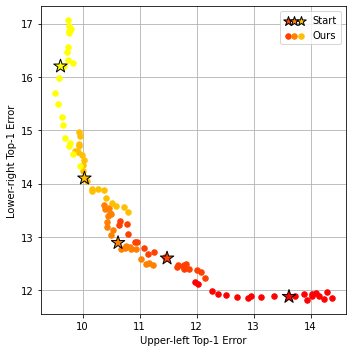

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = plt.get_cmap('autumn', num_weights)

total_top1s = []
for i in range(num_weights):
    ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
    losses, top1s = ckpt['metrics']
    total_top1s.append(top1s)
total_err1s = 100.0 * (1.0 - np.stack(total_top1s, axis=0).T)
ax.scatter(*total_err1s, color=[cmap(i) for i in range(num_weights)],
           marker='*', s=200, edgecolor='black', zorder=10)

for i in range(num_weights):
    total_top1s = []
    for col in range(2):
        for step in range(num_steps):
            ckpt = torch.load(mr_path / str(i) / str(col) /  '{:d}.pth'.format(step), map_location='cpu')
            losses, top1s = ckpt['metrics']
            total_top1s.append(top1s)
    total_err1s = 100.0 * (1.0 - np.stack(total_top1s, axis=0).T)
    ax.scatter(*total_err1s, color=cmap(i), marker='o', s=30)

ax.set_xlabel('Upper-left Top-1 Error')
ax.set_ylabel('Lower-right Top-1 Error')
ax.grid(True)
ax.set_axisbelow(True)

handles, labels = [], []
handles.append(
    tuple(ax.scatter([], [], color=cmap(i), marker='*', s=100, edgecolor='black') for i in range(1, 4)))
labels.append('Start')

handles.append(
    tuple(ax.scatter([], [], color=cmap(i), marker='o', s=30) for i in range(1, 4)))
labels.append('Ours')

ax.legend(handles, labels, handler_map={tuple: HandlerTuple(None, 0)})
fig.tight_layout()
plt.show()